In [ ]:
%%bash
python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ As of spaCy v3.0, shortcuts like 'de' are deprecated. Please use the
full pipeline package name 'de_core_news_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


2021-06-15 11:59:45.083786: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-15 11:59:50.499069: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
!pip install spacy --upgrade

Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.6)


In [ ]:
import os
import glob
import torch
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

from torchtext.legacy import data

import spacy
import numpy as np
import pandas as pd

import random
import math
import time

import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset


In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
df = pd.read_csv('full_question_answer_data.txt',sep='\t',encoding = "ISO-8859-1")
new_df = df[['Answer','Question']].dropna().reset_index(drop=True)
df.head()

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,data/set3/a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,data/set3/a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,data/set3/a4


In [ ]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(new_df,test_size=0.3)
train_df

,Answer,Question
3364,Yes,Does a violin have four strings?
3167,The Leningrad Philharmonic Orchestra,Give an example of the best known symphony orc...
3239,26,How many letters are in the basic Latin alphabet?
2078,Yes,Is / ref Swahili unusual among sub-Sahara...
750,Because of grazing,Why do kangaroos have a wide bite?
...,...,...
3276,The trumpet and trombone share a roughly cylin...,"Why do trumpets have a bright, loud sound?"
3125,"No, Portuguese is not an official language of ...",Is Portuguese an official language of Andorra?
1318,mud or sand,What are turtle eggs covered in when they incu...
723,Hamilton wanted to control the army differentl...,In what ways was Adams opposed by Anderw Hamil...


In [ ]:
test_df

,Answer,Question
1750,Yes,Did old English develop into Middle English?
2266,Yes,Is Avogadro hailed as a founder of the atomic-...
2297,die,What may happen to red fire ants if we use boi...
3161,railway,How to travel to work from the city to Moscow?
289,1967,When was the Six Day War?
...,...,...
2015,the Ottawa 67's,What is Ottawa's junior ice hockey team?
2308,Yes.,Do ants thrive in most ecosystems?
937,yes,Was Fillmore the first U.S. President born aft...
2017,Carleton Ravens,What are Carleton University's athletic teams ...


In [ ]:
import spacy
spacy_en = spacy.load('en_core_web_sm')

In [ ]:

class DataFrameDataset(data.Dataset):

    def __init__(self,df, fields, is_test=False, **kwargs):
        #self.df = pd.read_csv(root_dir,sep='\t',encoding='ISO-8859-1')
        #self.df = self.df[['Question','Answer']].dropna().reset_index()
        examples = []
        for i, row in df.iterrows():
            src = row.Question
            trg = row.Answer
            examples.append(data.Example.fromlist([src, trg], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
      return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field,True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [ ]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True
           )

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True
           )

In [ ]:
fields = [('src',SRC), ('trg',TRG)]

train_ds,test_ds= DataFrameDataset.splits(fields, train_df=train_df,test_df=test_df)

In [ ]:
SRC.build_vocab(train_ds, min_freq = 2)
TRG.build_vocab(train_ds, min_freq = 2)

In [ ]:
print(f"Unique tokens in source  vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target  vocabulary: {len(TRG.vocab)}")

Unique tokens in source  vocabulary: 2035
Unique tokens in target  vocabulary: 1294


In [ ]:
next(iter(train_ds)),next(iter(test_ds))

(<torchtext.legacy.data.example.Example at 0x7f3a307d0610>,
 <torchtext.legacy.data.example.Example at 0x7f395d1dc950>)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
SRC.vocab.stoi

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(SRC.vocab.stoi, tokens)

In [ ]:
device

device(type='cuda')

In [ ]:
BATCH_SIZE = 128

train_iterator, test_iterator = BucketIterator.splits(
    (train_ds, test_ds), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort=False
    )

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(2035, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(1294, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=1294, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,872,462 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
               
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
for i, batch in enumerate(test_iterator):
  print(i,batch)

0 
[torchtext.legacy.data.batch.Batch of size 128]
	[.src]:[torch.cuda.LongTensor of size 39x128 (GPU 0)]
	[.trg]:[torch.cuda.LongTensor of size 18x128 (GPU 0)]
1 
[torchtext.legacy.data.batch.Batch of size 128]
	[.src]:[torch.cuda.LongTensor of size 46x128 (GPU 0)]
	[.trg]:[torch.cuda.LongTensor of size 27x128 (GPU 0)]
2 
[torchtext.legacy.data.batch.Batch of size 128]
	[.src]:[torch.cuda.LongTensor of size 46x128 (GPU 0)]
	[.trg]:[torch.cuda.LongTensor of size 47x128 (GPU 0)]
3 
[torchtext.legacy.data.batch.Batch of size 128]
	[.src]:[torch.cuda.LongTensor of size 44x128 (GPU 0)]
	[.trg]:[torch.cuda.LongTensor of size 72x128 (GPU 0)]
4 
[torchtext.legacy.data.batch.Batch of size 128]
	[.src]:[torch.cuda.LongTensor of size 37x128 (GPU 0)]
	[.trg]:[torch.cuda.LongTensor of size 41x128 (GPU 0)]
5 
[torchtext.legacy.data.batch.Batch of size 128]
	[.src]:[torch.cuda.LongTensor of size 29x128 (GPU 0)]
	[.trg]:[torch.cuda.LongTensor of size 203x128 (GPU 0)]
6 
[torchtext.legacy.data.batch.B

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        #print('Test')
        for i, batch in enumerate(iterator):
           
            src = batch.src
            trg = batch.trg
           
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')
train_l = []
test_l = []
train_ppl = []
test_ppl = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    train_l.append(train_loss)
    train_ppl.append(f'{math.exp(train_loss):7.3f}')

    valid_loss = evaluate(model, test_iterator, criterion)
    test_l.append(valid_loss)
    test_ppl.append(f'{math.exp(valid_loss):7.3f}')
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    

Epoch: 01 | Time: 0m 2s
	Train Loss: 3.945 | Train PPL:  51.659
	 Val. Loss: 3.553 |  Val. PPL:  34.915
Epoch: 02 | Time: 0m 2s
	Train Loss: 3.881 | Train PPL:  48.483
	 Val. Loss: 3.548 |  Val. PPL:  34.730
Epoch: 03 | Time: 0m 2s
	Train Loss: 3.882 | Train PPL:  48.531
	 Val. Loss: 3.557 |  Val. PPL:  35.045
Epoch: 04 | Time: 0m 2s
	Train Loss: 3.847 | Train PPL:  46.835
	 Val. Loss: 3.551 |  Val. PPL:  34.861
Epoch: 05 | Time: 0m 2s
	Train Loss: 3.872 | Train PPL:  48.028
	 Val. Loss: 3.613 |  Val. PPL:  37.092
Epoch: 06 | Time: 0m 2s
	Train Loss: 3.790 | Train PPL:  44.255
	 Val. Loss: 3.560 |  Val. PPL:  35.147
Epoch: 07 | Time: 0m 2s
	Train Loss: 3.806 | Train PPL:  44.980
	 Val. Loss: 3.563 |  Val. PPL:  35.264
Epoch: 08 | Time: 0m 2s
	Train Loss: 3.808 | Train PPL:  45.059
	 Val. Loss: 3.554 |  Val. PPL:  34.968
Epoch: 09 | Time: 0m 2s
	Train Loss: 3.727 | Train PPL:  41.537
	 Val. Loss: 3.557 |  Val. PPL:  35.071
Epoch: 10 | Time: 0m 2s
	Train Loss: 3.676 | Train PPL:  39.482


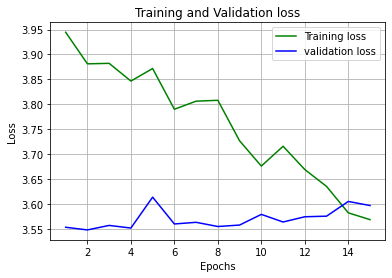

In [ ]:
#  training loss vs validation Accuracy
import matplotlib.pyplot as plt

epochs = range(1,16)
plt.plot(epochs, train_l, 'g', label='Training loss')
plt.plot(epochs, test_l, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
#load weights and tokenizer

path='./tut1-model.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)